# Simulate mean (theory) to mean (simulation)

In [44]:
from scipy.stats import lognorm
from scipy.stats import mode

import numpy as np
import matplotlib.pyplot as plt

def mode_theory(sigma: float, N: float, regime: int) -> float:
    """
    Ratio of a typical mean (mode of mean distribution) of sample size N to the true mean
    ratio = S_n^t / n<x>, where S_n^t is the typical sum of n samples, <x> is the average value of x.

    Regime 1: \sigma**2 << 1 (eq. 30 and below)
    Regime 2: \sigma**2 ~ 1  (eq. 37)
    Regime 3: \sigma**2 >> 1 (eq. 54 and 55)

    Args:
        sigma: standard deviation of the lognormal distribution
        N: sample size
        regime: regime of the lognormal distribution
    Returns:
        ratio: ratio of a typical mean (mode of mean distribution) of sample size N to the true mean
    """
    if regime == 1:
        ratio= 1.0
    elif regime == 2:
        C2 = np.exp(sigma**2) - 1.
        ratio = np.power(1. + C2/N, -3./2.)
    elif regime == 3:
        ratio = np.exp(-3/2.*sigma**2/np.power(N, np.log(3./2.)/np.log(2)))
    else:
        raise ValueError("Regime should be 1, 2 or 3")

    return ratio

def mode_montecarlo(sigma: float, mu: float, N: float, n_mc: int = 1000000, bin_low: float = 0.0001, bin_high=1.1) -> float:
    """ 
    Monte-Carlo simulation of the ratio of a typical mean (mode of mean distribution) of sample size N to the true mean
    Args:
        sigma: standard deviation of the lognormal distribution
        mu: mean of the lognormal distribution
        N: sample size
        n_mc: number of Monte-Carlo simulations
        bin_low: lower bound of the histogram
        bin_high: upper bound of the histogram
    Returns:
        mode_of_ratio: ratio of a typical mean (mode of mean distribution) of sample size N to the true mean    
    """
    true_mean = np.exp(mu+sigma**2/2) 

    # sample from lognormal distribution and compute mean for N stocks portfolio
    #r = lognorm.rvs(loc=mu, s=sigma, size=(n_mc, N)) 
    r = np.random.lognormal(mu, sigma,size=(n_mc,N))
    r_mean=r.mean(axis=1)

    counts, bins = np.histogram(r_mean/true_mean, bins=np.linspace(bin_low, bin_high, 10000))

    mode_of_ratio = bins[np.argmax(counts)]
    return mode_of_ratio

Function for test and real data for lognormal distribution parameters:

In [45]:
def get_test_sigma_dict(regime: int) -> dict:
    """ 
    Get mocking lognorormal distribution parameters for regime 1, 2 and 3
    Args:
        regime: regime of the lognormal distribution
    Returns:
        sigma_dict: dictionary of standard deviation of the lognormal distribution
    """
    if regime == 1:
        sigma_dict = {'A': {'mu': 0.0, 'sigma': 0.01},
                      'B': {'mu': 0.0, 'sigma': 0.05},
                      'C': {'mu': 0.0, 'sigma': 0.10}}
    elif regime == 2:
        sigma_dict = {'A': {'mu': 0.0, 'sigma': 0.2},
                      'B': {'mu': 0.0, 'sigma': 0.5},
                      'C': {'mu': 0.0, 'sigma': 1.2}}
    elif regime == 3:
        sigma_dict = {'A': {'mu': 0.0, 'sigma': 5.0},
                      'B': {'mu': 0.0, 'sigma':10.0},
                      'C': {'mu': 0.0, 'sigma':100.0}}
    else:
        raise ValueError("Regime should be 1, 2 or 3")
    return sigma_dict

def get_real_sigma_dict(regime: int) -> dict:
    """"""
    sigma_dict = {'UKX': {'mu': 0.72, 'sigma': 0.83},
                  'NKY': {'mu': 0.21, 'sigma': 0.87},
                  'SPX': {'mu': 0.95, 'sigma': 1.02},
                  'NIFTY': {'mu': 1.65, 'sigma': 1.23},
                  }
    return sigma_dict

Model theoretical and monte-carlo ratio:

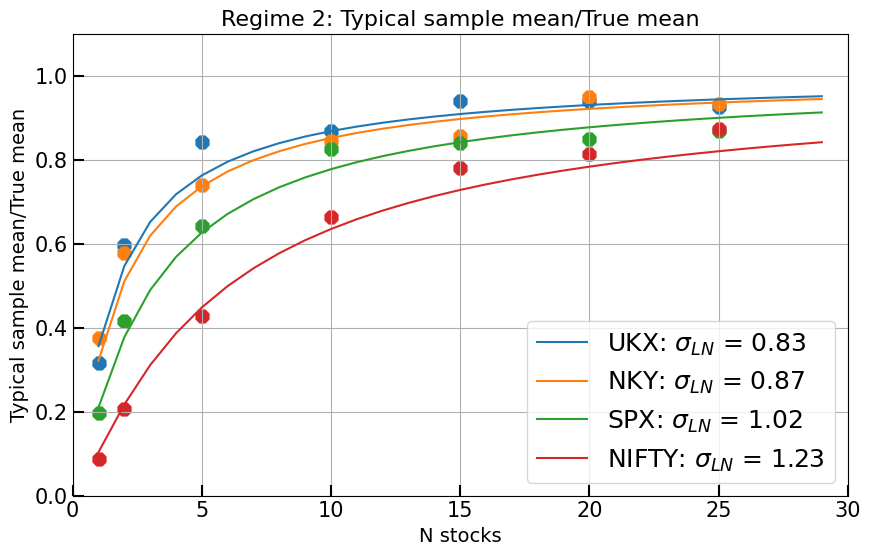

In [46]:
n_portfolio = range(1,30)               # sample size/portfolio size 
n_portfolio_mc = [1,2,5,10,15,20,25]    # points for mc simulation

regime = 2

sigma_dict = get_real_sigma_dict(regime)

plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.rcParams['axes.linewidth'] = 2.0

for index_name in sigma_dict:

    # parameters of the lognormal distribution
    sigma_ln = sigma_dict[index_name]['sigma']
    mu_ln = sigma_dict[index_name]['mu']

    # theoretical 
    mode_th = [mode_theory(sigma_ln, N, regime=regime) for N in n_portfolio]

    # monte-carlo simulation  
    mode_mc = [mode_montecarlo(sigma_ln, mu_ln, N, bin_low=0.01, bin_high=1.1) for N in n_portfolio_mc]

    plt.plot(n_portfolio, mode_th, label = index_name + r': $\sigma_{LN}$ = ' + str(sigma_ln))
    plt.scatter(n_portfolio_mc, mode_mc, marker='8', s=100)

ax.set_xlabel('N stocks', size=14)
ax.set_ylabel('Typical sample mean/True mean', size = 14) 
ax.set_title(f'Regime {regime}: Typical sample mean/True mean', size=16)

ax.set_xlim([0, 30])   
ax.set_ylim([0,1.1]) 

ax.legend(loc ='lower right', fontsize=18)

ax.tick_params(axis='both', which='major', direction='in', length=8, width=1.5, colors='black', labelsize=15)

plt.grid()
#plt.legend() 
plt.savefig('sample_mean_vs_true_mean.png', dpi=300, bbox_inches='tight')  